# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [12]:
import patsy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

from statsmodels.regression.quantile_regression import QuantReg

#!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
sns.set_style('white')
DPI = 175
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 4.4, 3.0  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

In [0]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 4)[1]

## Import Data

In [15]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

bwt  gestation  parity  age  height  weight  smoke
0  120        284       0   27      62     100      0
1  113        282       0   33      64     135      0
2  128        279       0   28      64     115      1
3  108        282       0   23      67     125      1
4  136        286       0   25      62      93      0

In [16]:
bwt_df.shape

(1174, 7)

In [17]:
bwt_df.describe()

bwt    gestation       parity          age       height  \
count  1174.000000  1174.000000  1174.000000  1174.000000  1174.000000   
mean    119.462521   279.101363     0.262351    27.228279    64.049404   
std      18.328671    16.010305     0.440100     5.817839     2.526102   
min      55.000000   148.000000     0.000000    15.000000    53.000000   
25%     108.000000   272.000000     0.000000    23.000000    62.000000   
50%     120.000000   280.000000     0.000000    26.000000    64.000000   
75%     131.000000   288.000000     1.000000    31.000000    66.000000   
max     176.000000   353.000000     1.000000    45.000000    72.000000   

            weight        smoke  
count  1174.000000  1174.000000  
mean    128.478705     0.390971  
std      20.734282     0.488176  
min      87.000000     0.000000  
25%     114.250000     0.000000  
50%     125.000000     0.000000  
75%     139.000000     1.000000  
max     250.000000     1.000000

In [18]:
# Data looks pretty clean and simple. 
bwt_df.head()

bwt  gestation  parity  age  height  weight  smoke
0  120        284       0   27      62     100      0
1  113        282       0   33      64     135      0
2  128        279       0   28      64     115      1
3  108        282       0   23      67     125      1
4  136        286       0   25      62      93      0

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


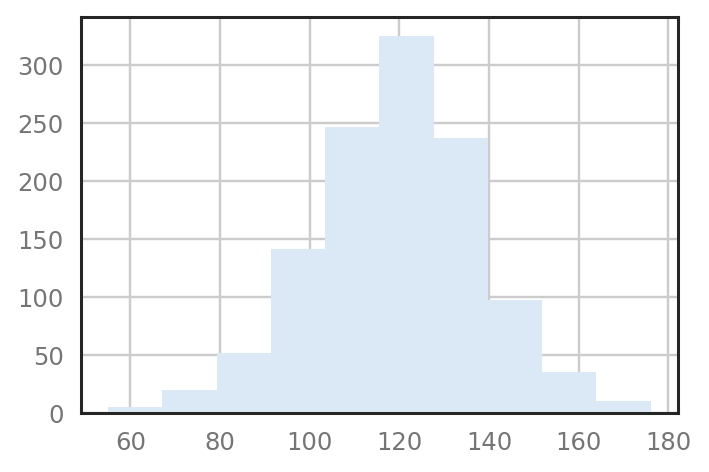

In [19]:
bwt_df.bwt.hist()

### Calculate the quantile from a percentile score of the BWT, then run QuantReg

In [20]:
# What quantile corresponds to a birth weight of 90 oz? 
q = stats.percentileofscore(bwt_df.bwt, 90)/100

# Then lets check out some regression
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

data=bwt_df

mod = smf.quantreg(quant_formula, data)
res = mod.fit(q=q)
print(res.summary())  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke
                         QuantReg Regression Results                          
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.228
Method:                 Least Squares   Sparsity:                        132.4
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        10:24:12   Df Residuals:                     1167
                                        Df Model:                            6
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.271     -32.393
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1

## Compare to OLS Intercept / Coefficients

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


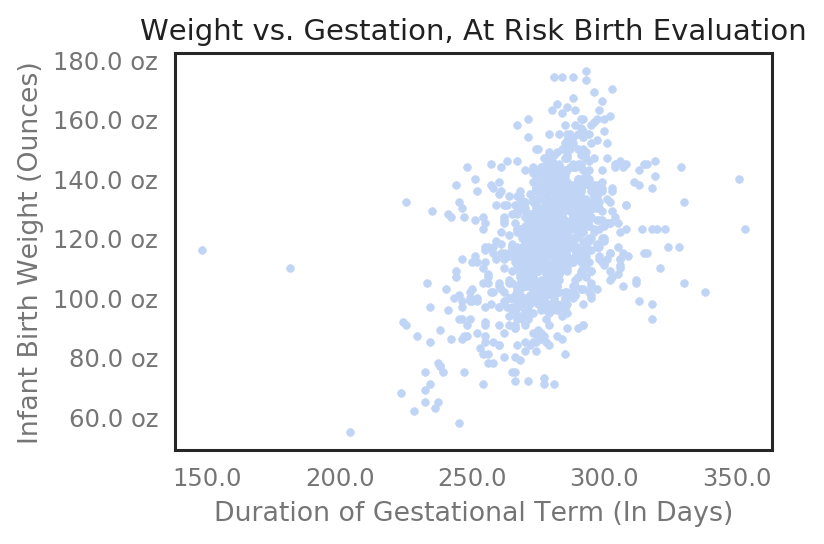

In [22]:
from matplotlib.ticker import FuncFormatter

ax = plt.scatter(x=bwt_df.gestation, y=bwt_df.bwt, color=dot_color, s= 10)
plt.title('Weight vs. Gestation, At Risk Birth Evaluation', loc='center')
#sns.despine(left=True, bottom=True)
ax.axes.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: '{}'.format(x)))
ax.axes.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: '{} oz'.format(y)))
plt.xlabel('Duration of Gestational Term (In Days)')
plt.ylabel('Infant Birth Weight (Ounces)')
plt.show()

In [21]:
# Compare to the OLS Coefficients
X = bwt_df.drop('bwt', axis='columns')
y = bwt_df['bwt']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

coefficients = linear_reg.coef_    # array
intercept = linear_reg.intercept_

print(f"Intercept   : {intercept:.2f}")
print("Coefficients:")
for var, coef in zip(X.columns, coefficients):
    print(f'{var:>12}: {coef:.3f}')

Intercept   : -80.41
Coefficients:
   gestation: 0.444
      parity: -3.327
         age: -0.009
      height: 1.154
      weight: 0.050
       smoke: -8.401


## OLS vs QuantReg - Plot Type 1

Multiple quantile regressors vs OLS regressor line. 

This plot compares best fit lines for 10 quantile regression models to the least squares fit. As Koenker and Hallock (2001) point out, we see that:

1. Birthweight increases with gestation
2. The dispersion of birthweight remains mostly consistent with gestation
3. The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households)

In [0]:
mod = smf.quantreg('bwt ~ gestation', data)
res = mod.fit(q=.5)

In [24]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['gestation']] + \
            res.conf_int().loc['gestation'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])

ols = smf.ols('bwt ~ gestation', data).fit()
ols_ci = ols.conf_int().loc['gestation'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['gestation'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05 -47.000000  0.500000  0.296613  0.703387
1  0.15 -37.500002  0.500000  0.374042  0.625958
2  0.25 -31.000024  0.500000  0.397075  0.602925
3  0.35 -32.340900  0.522727  0.438569  0.606886
4  0.45 -27.080005  0.520000  0.449395  0.590605
5  0.55 -27.000000  0.531250  0.464915  0.597585
6  0.65 -14.499998  0.500000  0.432593  0.567407
7  0.75  -3.380971  0.476191  0.397027  0.555354
8  0.85  51.111111  0.305556  0.191546  0.419565
9  0.95  40.033612  0.386555  0.176611  0.596499
{'a': -10.754138914450326, 'b': 0.46655687694921555, 'lb': 0.40664351443120883, 'ub': 0.5264702394672223}


Text(0.5, 1.0, 'Birth Weight by Gestation')

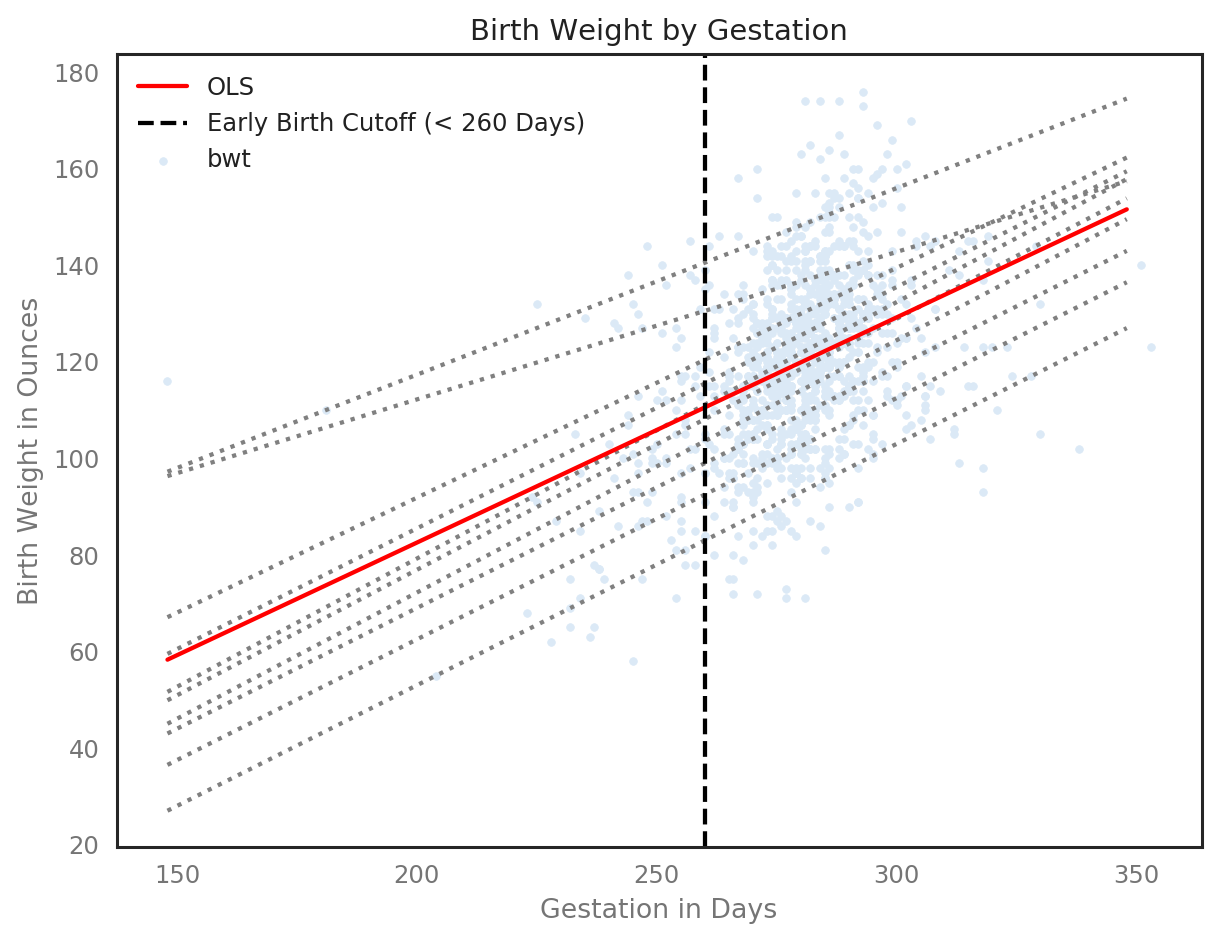

In [31]:
x = np.arange(data.gestation.min(), data.gestation.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.gestation, data.bwt, alpha=1, s= 10)

# cutoff for early birth binary variable
ax.axvline(x=260, c='black', linestyle='--', label='Early Birth Cutoff (< 260 Days)')

legend = ax.legend()
ax.set_xlabel('Gestation in Days')
ax.set_ylabel('Birth Weight in Ounces');
ax.set_title('Birth Weight by Gestation')

## OLS vs QuantReg - Plot Type 2 
## "AKA LOOK HOW MUCH BETTER THIS PERFORMS"
The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confindence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

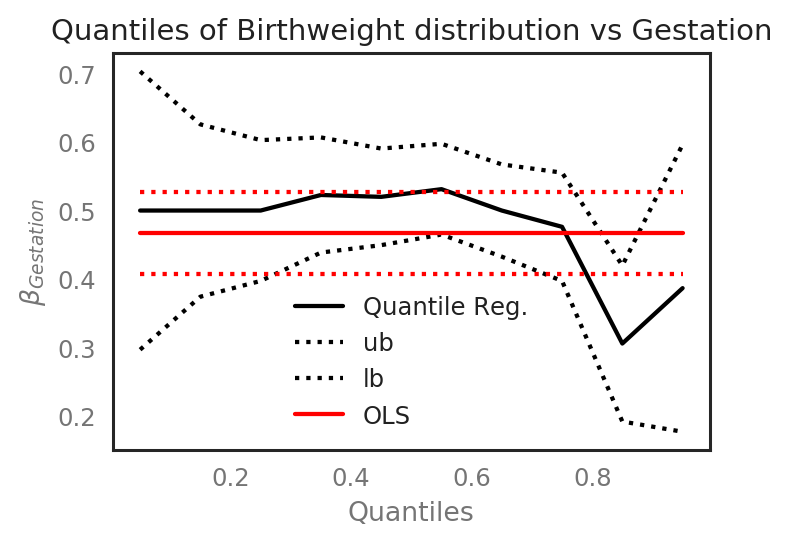

In [34]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Gestation}$')
plt.xlabel('Quantiles')
plt.title('Quantiles of Birthweight distribution vs Gestation')
plt.legend()
plt.show()

# Summary

**DEAR MOMS:**
* Don't Smoke.
* Keep the baby cooking till you reach full term.
* Enjoy the remaining bit of silent sleeping before your little one arrives. 

And congratulations on embarking on this most excellent journey of parenthood! It's incredibly rough at times, but it's worth it. 

## Resources

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)
- [more Quant learning](https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629)
- [An overview of QuantRegression from statsmodels to deep learning](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3)